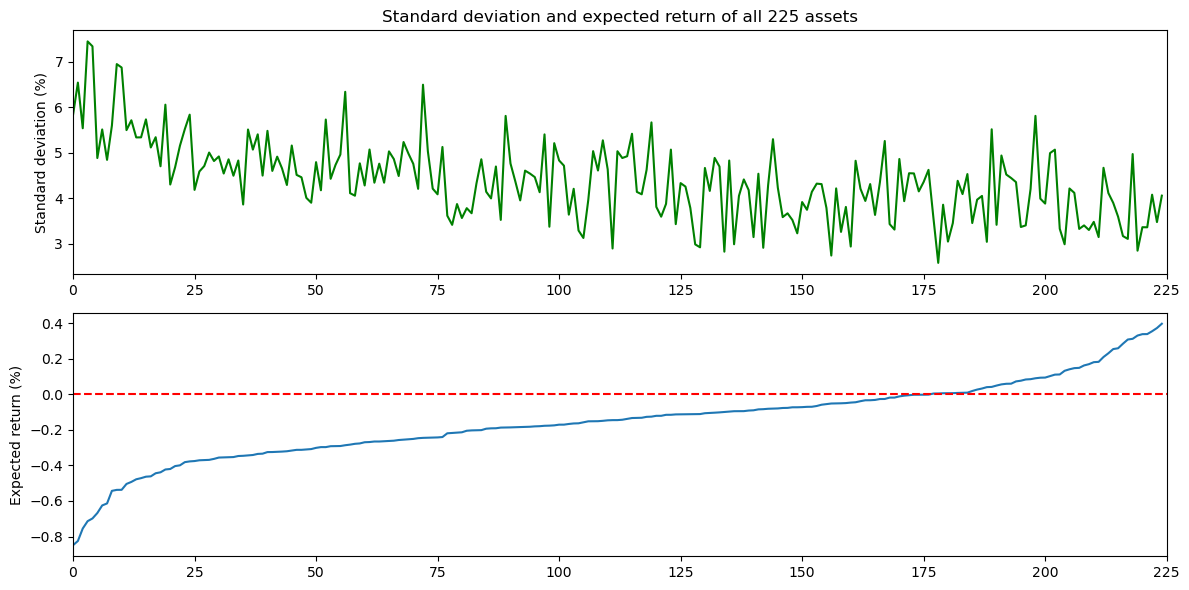

In [2]:
#If you don't have CSV and/or DataFrames:
#using Pkg
#Pkg.add("CSV")
#Pkg.add("DataFrames")
#Pkg.add("LinearAlgebra")

using CSV
using DataFrames
using LinearAlgebra

mudata = CSV.read("folio_mean.csv", DataFrame, header=0)
covdata = CSV.read("folio_cov.csv", DataFrame, header=0)

μ = 100*vec(Matrix(mudata))  # Expected return (in percent)
Σ = 10000*Matrix(covdata)    # Expected variance (in percent squared)

ix = sortperm(μ);   # sort the assets by expected return

using PyPlot
fig = figure(figsize=(12,6))

subplot(211)
xlim(0,225)
plot(sqrt.(diag(Σ))[ix],"g")
ylabel("Standard deviation (%)")
title("Standard deviation and expected return of all 225 assets")
tight_layout()

subplot(212)
xlim(0,225)
plot(μ[ix])
plot([0,225],[0,0],"r--")
ylabel("Expected return (%)")
tight_layout()
#savefig("folio1_vals.pdf")
;

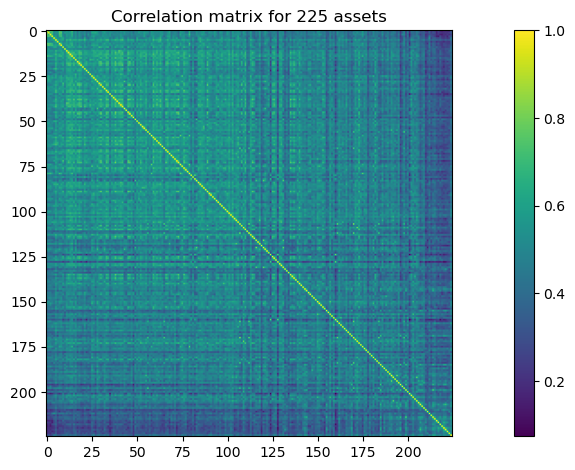

In [3]:
# plot correlation matrix (shows which assets are correlated with which other assets)
corr = diagm(diag(Σ).^(-1/2))*Σ*diagm(diag(Σ).^(-1/2))
imshow(corr[ix,ix]);colorbar();axis("image")
title("Correlation matrix for 225 assets")
tight_layout()
#savefig("folio2_cov.pdf")

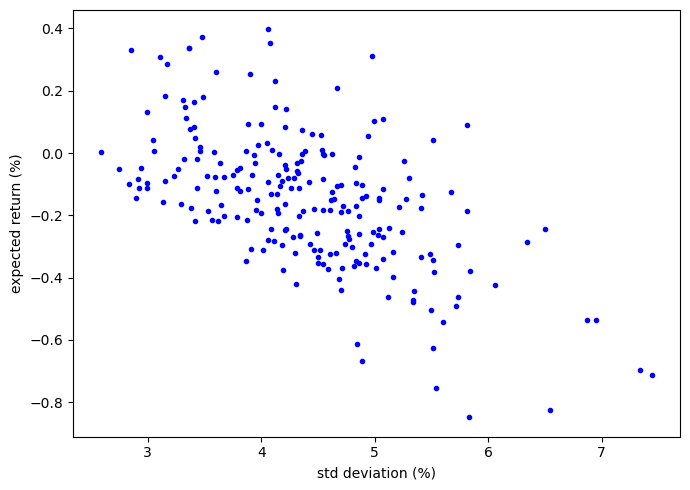

In [4]:
# plot each asset individually
figure(figsize=(7,5))
plot(sqrt.(diag(Σ)), μ, "b.")
xlabel("std deviation (%)")
ylabel("expected return (%)")
tight_layout()
#savefig("folio3_assets.pdf")
;

In [5]:
# compute optimal tradeoff curve (this may take a few seconds)
N = 50
ret = zeros(N)
std = zeros(N)
#Logaritmically space lambda between 10^-3 and 10^4
lambda_values = 10 .^(range(-3,stop=4,length=N))

using JuMP, Ipopt
m = Model(Ipopt.Optimizer)
@variable(m, x[1:225] >= 0)
@constraint(m, sum(x) == 1)

for (i,λ) in enumerate(lambda_values)
    @objective(m, Min, -dot(μ,x) + λ*dot(x,Σ*x) )
    optimize!(m)
    xsol = value.(x)
    ret[i] = dot(μ,xsol)
    std[i] = sqrt(dot(xsol,Σ*xsol))
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      225
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    25425

Total number of variables............................:      225
                     variables with only lower bounds:      225
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality co

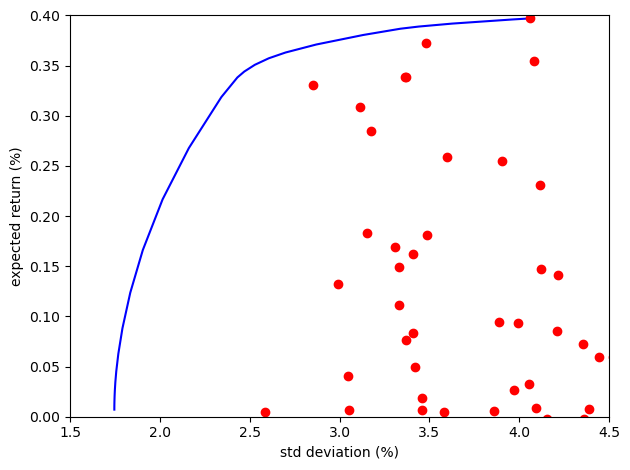

In [10]:
# plot tradeoff curve
plot(std,ret,"b-")
plot(sqrt.(diag(Σ)), μ, "r.", markersize=12)
xlabel("std deviation (%)")
ylabel("expected return (%)")
axis([1.5,4.5,0,.4]);
tight_layout()
#savefig("folio5_pareto.pdf")